In [2]:
!python --version
%pip install --upgrade pandas
%pip install openpyxl
%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install plot_keras_history
%pip install tensorflow
%pip install keras-tuner
%pip install -q keras-tcn --no-dependencies

Python 3.11.5


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [2]:
import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib

from tcn import TCN, tcn_full_summary

print("TF version:", tf.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Historico de datos para realizar la predicción
W = 729
# Insantes de tiempo futuros a predecir
H = 10

# Porcentaje del conjunto de test
test_size = 0.3
# Porcentaje del conjunto de validacion
val_size = 0.3

# Establecer objetivo (Name of model metric to minimize or maximize, e.g. "val_accuracy"). el "val_" hace referencia a que se coge la métrica en el subconjunto de validación

# obje = kerastuner.Objective('val_mean_absolute_percentage_error', 'min')

# Epocas
epchs=1000
# Tamaño del batch
batch = 1024

# Establecer minimo y maximo de capas y el valor por defecto
minLayers = 1
maxLayers = 10
defaultLayers = 3

# Establecer learning rate
lr = [0.0, 1e-2, 1e-3, 1e-4]


TF version: 2.15.0
Panda version: 2.1.4
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Please install GPU version of TF
Num GPUs Available:  0
Build with CUDA:  False


In [3]:
df = pd.read_excel("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/2015_30min.xlsx", header=None, engine='openpyxl')[0]

# Data preprocessing: each row will contain the 10 measures for each day , and the 10 measures for the following day
#X = pd.DataFrame(np.array(df).reshape(-1, 10), columns=["col_{}".format(i) for i in range(0, 10)])
X = pd.DataFrame(np.array(df).reshape(-1, 10))
Y = pd.DataFrame.copy(X)

Y.columns = ["col_{}".format(i) for i in range(11, 21)]
Y = Y.drop(0)
Y = Y.reset_index(drop=True)
Y.loc[len(Y)] = np.zeros(10)

dfNoNormalized = pd.concat([X, Y], axis=1)

dataToPredict = dfNoNormalized.tail(1)
print("Row for predicting: ", dataToPredict)

# Data Normalization
scaler = MinMaxScaler()
XNormalized = pd.DataFrame(scaler.fit_transform(X), columns=["col_{}".format(i) for i in range(0, 10)])
YNormalized = pd.DataFrame(scaler.fit_transform(Y), columns=["col_{}".format(i) for i in range(11, 21)])

dfPreproccessed = pd.concat([XNormalized, YNormalized], axis=1)

# Last row is deleted beacuse it is the one for used for the real prediction, it is not useful for the training of the model.
print(len(dfPreproccessed))
dfPreproccessed.drop(dfNoNormalized.tail(1).index, inplace=True)
print(len(dfPreproccessed))

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

pd.set_option('display.max_columns', dfPreproccessed.shape[1])
print("Head DataFrame Preprocessed\n " + str(dfPreproccessed.head()))
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xTest, yTrain, yTest = train_test_split(XNormalized, YNormalized, test_size = test_size, random_state = 0, shuffle=False)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size = val_size, random_state = 0, shuffle=False)

# Show subsets shapes
print("Shapes:")
print("xTrain:\t"+str(xTrain.shape))
print("yTrain:\t"+str(yTrain.shape))
print("xVal:\t"+str(xVal.shape))
print("yVal:\t"+str(yVal.shape))
print("xTest:\t"+str(xTest.shape))
print("yTest:\t"+str(yTest.shape))

print("---------------------------------------------")

Row for predicting:                0           1         2           3           4           5  \
729  467.921333  417.395833  578.1815  655.602167  524.690833  601.943333   

              6           7           8           9  col_11  col_12  col_13  \
729  494.858833  382.829667  374.602167  244.221667     0.0     0.0     0.0   

     col_14  col_15  col_16  col_17  col_18  col_19  col_20  
729     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
730
729
DataFrame Preproccessed:
        col_0     col_1     col_2     col_3     col_4     col_5     col_6  \
0    0.107444  0.214869  0.823713  0.681291  0.579754  0.748729  0.996273   
1    0.953252  0.846820  1.000000  0.864730  0.964078  0.816509  0.716787   
2    0.226250  0.184588  0.473271  0.392818  0.828149  0.840272  0.959504   
3    0.728817  0.753921  0.826953  0.507657  0.252715  0.135377  0.237886   
4    0.122191  0.167726  0.096025  0.153204  0.233967  0.332163  0.262094   
..        ...       ...       ...       ...   

In [6]:
# Model definition

model = keras.models.Sequential()
model.add(TCN(
    input_shape=(xTrain.shape[1], 1), 
    nb_filters=256, 
    return_sequences=True,
    dilations=[1, 2, 4, 8, 16, 32]))
model.add(keras.layers.Dense(1, activation="sigmoid"))

print("Model Summary: ", model.summary())

# Model compilation
model.compile(loss="mean_squared_error",
            optimizer="adam",
            metrics=[keras.metrics.MAE, keras.metrics.MAPE, keras.metrics.MSE])

history = model.fit(
    np.reshape(xTrain.values, (xTrain.shape[0], xTrain.shape[1], 1)),
    yTrain,
    epochs=epchs,
    batch_size=batch,
    validation_data=(np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1)), yVal))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_2 (TCN)                 (None, 10, 256)           2167040   
                                                                 
 dense_2 (Dense)             (None, 10, 1)             257       
                                                                 
Total params: 2167297 (8.27 MB)
Trainable params: 2167297 (8.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model Summary:  None
Epoch 1/1000


1/1 [==============================] - 4s 4s/step - loss: 0.1716 - mean_absolute_error: 0.3465 - mean_absolute_percentage_error: 497126.2188 - mean_squared_error: 0.1716 - val_loss: 0.1718 - val_mean_absolute_error: 0.3507 - val_mean_absolute_percentage_error: 95.7070 - val_mean_squared_error: 0.1718
Epoch 2/1000
1/1 [==============================] - 1s 691ms/step - loss: 

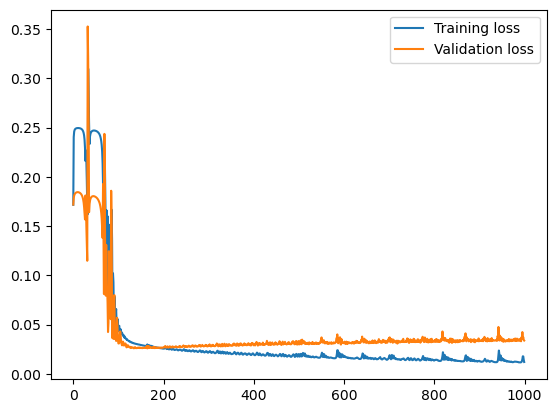

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [7]:
# Training and Validation loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xVal.reshape((xVal.shape[0], xVal.shape[1], 1)), yVal)
print('Score:', score)